In [ ]:
!pip install pafy youtube-dl moviepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.9 MB/s eta 0:00:00


In [ ]:
from ast import increment_lineno
import os
import cv2
import pafy
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
import random

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model



In [ ]:
SeedConstant = 27
np.random.seed(SeedConstant)
random.seed(SeedConstant)
tf.random.set_seed(SeedConstant)

In [ ]:
# Getting the dataset and extracting it
%%capture

!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

!unrar x UCF50.rar


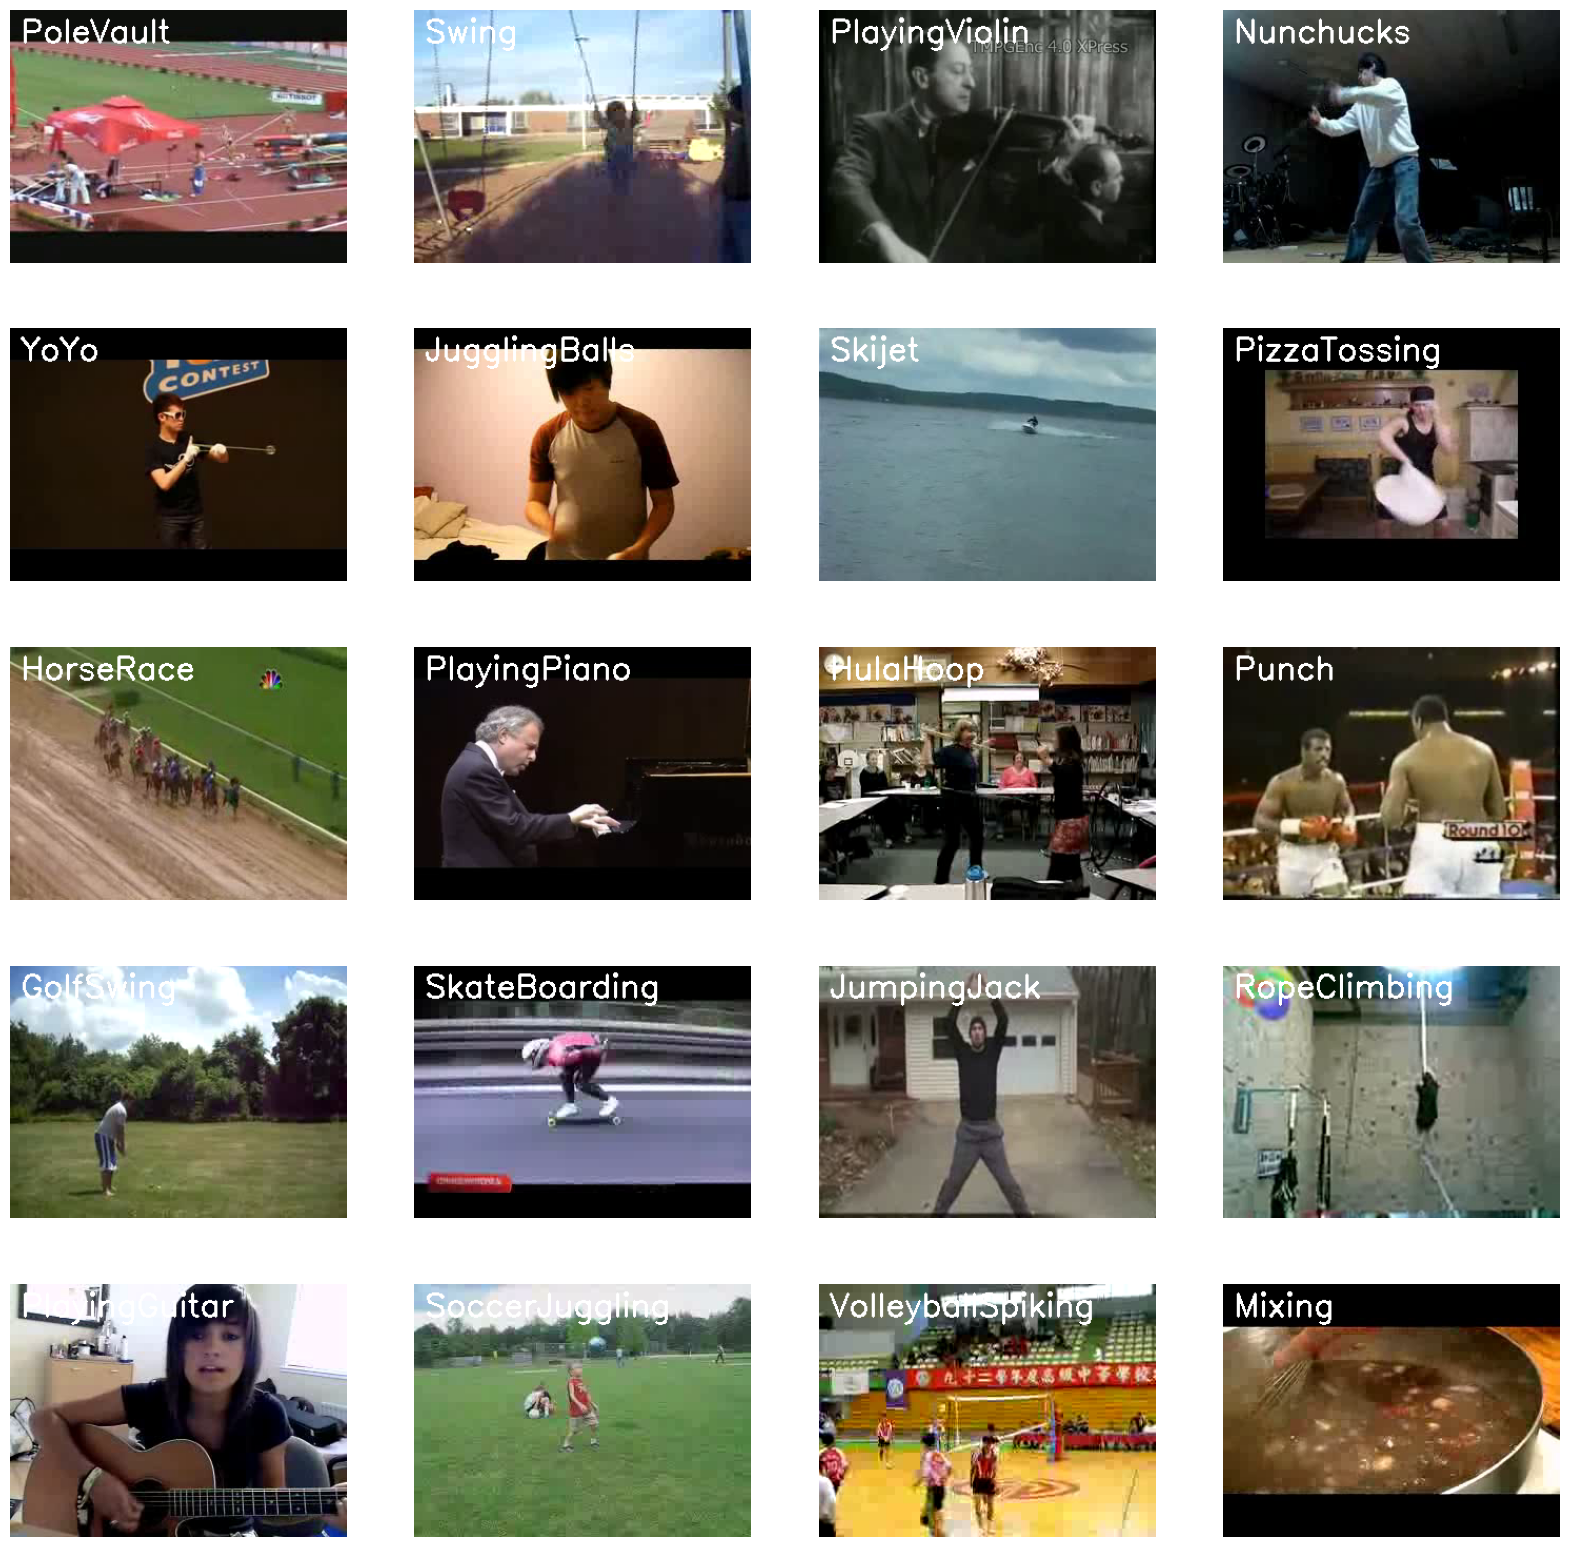

In [ ]:
plt.figure(figsize = (20,20))

# Get the names of all the classes inside the UCF50 dataset
ClassesNames = os.listdir("UCF50")

# Generating a list of 20 random values. THese values will be between 0 to 50
# The 50 is the total number of class inside the dataset

RandomRange = random.sample(range(len(ClassesNames)),20)

# Iterating through the generated random values
for counter, RandomIndex in enumerate (RandomRange):

  # Retrieving a Class Name using the random index
  SelectedClassName = ClassesNames[RandomIndex]

  # Retrieve the list of all the video files present in the randomly selected Class Dir
  VideoFilesList = os.listdir(f'UCF50/{SelectedClassName}')

  #Randomly selecting a video file from the list which is retrieved from the selected class specific category
  SelectedVideoName = random.choice(VideoFilesList)

  # Initializing the Video Capture Object to read from the video
  VideoReader = cv2.VideoCapture(f'UCF50/{SelectedClassName}/{SelectedVideoName}')

  # Reading just the 1st frame of the Video
  _, bgrFrame = VideoReader.read()

  # Releasing the VideoCapture Ibject
  VideoReader.release()

  # BGR to RGB
  rgbFrame = cv2.cvtColor(bgrFrame,cv2.COLOR_BGR2RGB)

  # Writing the clas name on the Video Frame for Ref
  cv2.putText(rgbFrame,SelectedClassName,(10,30),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2 )

  # Displaying the Frame
  plt.subplot(5, 4, counter + 1); plt.imshow(rgbFrame); plt.axis('off')

plt.show()





In [ ]:
# Preprocessing the Dataset

# Height and Width of Video Frame
ImageHeight, ImageWidth = 64,64

# Number of Frames per video
SequenceLength = 20

# Specifying the Directory
DatasetDir = 'UCF50'

# List of classes used for Training
ClassTrainList = ['Lunges','JumpRope','JumpingJack','PushUps']


In [ ]:
# Creating Function to Extract the Frames and Normalize it

def FramesExtraction(VideoPath):

  # Array to store the video Frames
  FrameList = []

  # Reading the video files using the VideoCapture
  VideoReader = cv2.VideoCapture(VideoPath)

  # Getting Total number of frames inside the video
  VideoFrameCount = int(VideoReader.get(cv2.CAP_PROP_FRAME_COUNT))

  # Calculating the Interval frames will be added to FrameList
  SkipFrameWindow = max(int(VideoFrameCount/SequenceLength),1)

  # Iterating through the Video Frames
  for FrameCounter in range(SequenceLength):

    # Current Frame Position
    VideoReader.set(cv2.CAP_PROP_POS_FRAMES,FrameCounter * SkipFrameWindow)

    # Reading the Frame in the video
    success, Frame = VideoReader.read()

    if not success:
      break

    # Resizing the frame
    ResizedFrame = cv2.resize(Frame,(ImageHeight,ImageWidth))

    # This Normalization helps in training where the iamge is scaled down to 0 to 1
    NormalizedFrame = ResizedFrame/255

    # Append the Normalized Frame to the FrameList
    FrameList.append(NormalizedFrame)

  VideoReader.release()
  return FrameList

In [ ]:
# Function to Create a Dataset
def CreateDataset():
  # Declaring Empty Arrays to store the features, labels and video path
  Features = [] # Pre-Processed
  Labels = [] # Class Name
  VideoFilePaths = []

  # Iterating through the classes mentioned in the Class List
  for ClassIndex, ClassName in enumerate (ClassTrainList):

    #Display the name of the Class which is extracted
    print(f'Extracting Data of Class: {ClassName}')

    # Get the list of video files present in the specific class
    FilesList = os.listdir(os.path.join(DatasetDir,ClassName))


    # Iterating through the files present in the files list
    for FileName in FilesList:

      # Getting the File path
      VideoFilePath = os.path.join(DatasetDir,ClassName,FileName)

      # Extracting the Frames from the video
      # This gives 20 preprocessed video
      Frames = FramesExtraction(VideoFilePath)


      # Checking whether the extracted frames are equal to Sequence Length
      if len (Frames) == SequenceLength:

        # Append the data to the respective list
        Features.append(Frames)
        Labels.append(ClassIndex)
        VideoFilePaths.append(VideoFilePath)

    # Converting the list to Numpy Array
  Features = np.array(Features)
  Labels = np.array(Labels)

# Return Frames, Class, Index, File Path
  return Features, Labels,VideoFilePaths



In [ ]:
# Create the Dataset
Features, Labels, VideoFilePaths = CreateDataset()

Extracting Data of Class: Lunges
Extracting Data of Class: JumpRope
Extracting Data of Class: JumpingJack
Extracting Data of Class: PushUps


In [ ]:
# Using Keras (to_categorical method) to convert labels in to onehot encoded vectors
OneHotEncoded_Labels = to_categorical(Labels)

In [ ]:
from tensorflow.python.ops.gen_array_ops import OneHot
# Splitting Data to TRAIN AND TEST

FeaturesTrain, FeaturesTest, LabelsTrain, LabelsTest = train_test_split(Features, OneHotEncoded_Labels,
                              test_size=0.25, shuffle = True, random_state=SeedConstant)

In [ ]:
# Constructing LSTM Model

def ConvLSTM_Model():

  # Sequential Model is used for constructing the model
  Model = Sequential()

  # Model Architecture
  # More the number of Filters more the accurate
  # Each Filter will give one feature map
  Model.add(ConvLSTM2D(filters = 4, kernel_size=(3,3),activation='tanh',
            data_format = "channels_last",recurrent_dropout =0.2, return_sequences = True,
            input_shape = (SequenceLength,ImageHeight,ImageWidth,3)))

  # Pooling operation is used to reduce the size of the network.
  # We're using 3D because of various number of frames in the video
  Model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format = 'channels_last'))
  Model.add(TimeDistributed(Dropout(0.2)))

  Model.add(ConvLSTM2D(filters = 8, kernel_size=(3,3),activation='tanh',
            data_format = "channels_last",recurrent_dropout =0.2, return_sequences = True))

  Model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format = 'channels_last'))
  Model.add(TimeDistributed(Dropout(0.2)))

  Model.add(ConvLSTM2D(filters = 14, kernel_size=(3,3),activation='tanh',
            data_format = "channels_last",recurrent_dropout =0.2, return_sequences = True))

  Model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format = 'channels_last'))
  Model.add(TimeDistributed(Dropout(0.2)))

  Model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3),activation='tanh',
            data_format = "channels_last",recurrent_dropout =0.2, return_sequences = True))

  Model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format = 'channels_last'))
  #Model.add(TimeDistributed(Dropout(0.2)))

  Model.add(Flatten()) # This combines all the features map into one

  # activation = softmax ==> This softmax spreads equally the probability
  # - between the layers as in total the no. of probability is 1
  Model.add(Dense(len(ClassTrainList),activation = "softmax"))

  # Displaying the model summary
  Model.summary()
  # Return the constructed Model
  return Model


In [ ]:
# Now running the model by calling the function
Create_ConvLSTM_Model =  ConvLSTM_Model()

# Displaying the success Message
print("Model built successfully")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

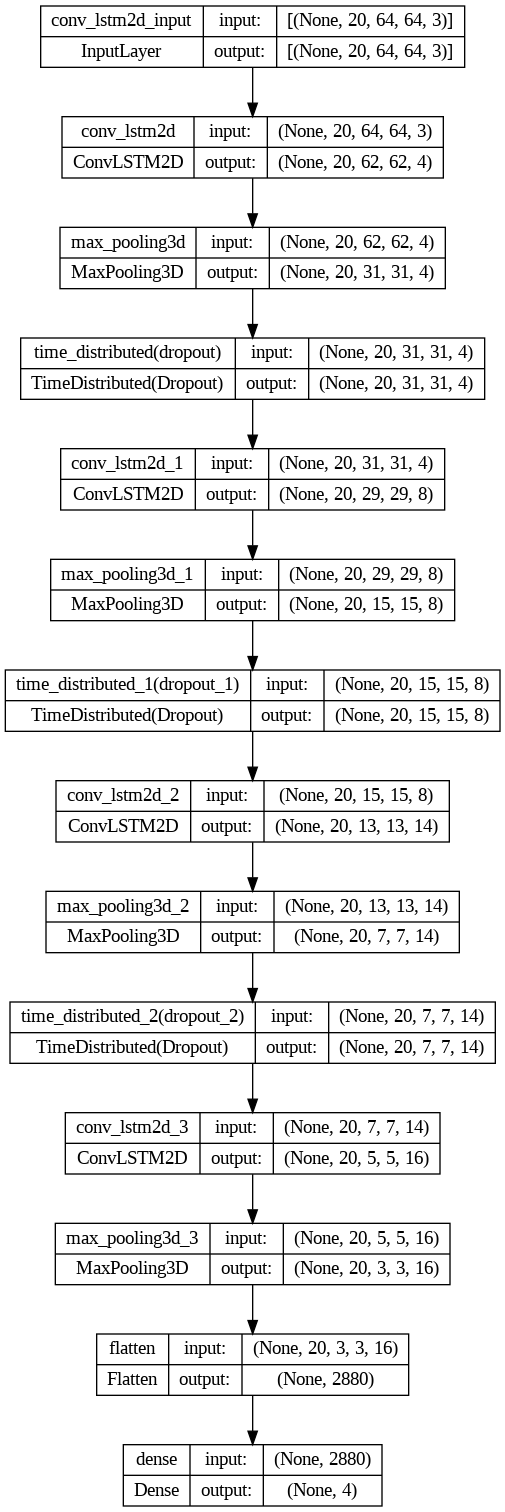

In [ ]:
# Plotting the structure of the model
plot_model(Create_ConvLSTM_Model, to_file = "ConvLSTM_Model_StructurePLot.png",
           show_shapes = True, show_layer_names = True)

In [ ]:
from keras.api._v2.keras import callbacks
# Compiling and Training the Model

# Creating Instance of Early Stopping Calbacks
# This early stopping saves the computation, like if val loss is not decreasing for 10 then it stops there
# If the best epoch is reached the weights are stored back in restore_best_weights
EarlyStopping_CallBack = EarlyStopping(monitor="val_loss",patience=10,
                                       mode = "min",restore_best_weights = True)

# Specify the Loss Function

Create_ConvLSTM_Model.compile(loss= "categorical_crossentropy",optimizer = "Adam",
                              metrics = ["accuracy"])

# Start Training the model

ConvLSTM_Model_Training_History = Create_ConvLSTM_Model.fit(x=FeaturesTrain,y = LabelsTrain, epochs=50,
                                    shuffle = True, validation_split = 0.2,
                                callbacks = [EarlyStopping_CallBack])


Epoch 1/50
10/10 [==============================] - 236s 21s/step - loss: 1.3837 - accuracy: 0.2871 - val_loss: 1.3673 - val_accuracy: 0.3718
Epoch 2/50
10/10 [==============================] - 169s 17s/step - loss: 1.3096 - accuracy: 0.4129 - val_loss: 1.5090 - val_accuracy: 0.4103
Epoch 3/50
10/10 [==============================] - 159s 16s/step - loss: 1.1933 - accuracy: 0.4548 - val_loss: 1.2805 - val_accuracy: 0.3974
Epoch 4/50
10/10 [==============================] - 218s 22s/step - loss: 1.1266 - accuracy: 0.5452 - val_loss: 1.2928 - val_accuracy: 0.4615
Epoch 5/50
10/10 [==============================] - 230s 23s/step - loss: 1.0676 - accuracy: 0.5548 - val_loss: 1.1437 - val_accuracy: 0.4872
Epoch 6/50
10/10 [==============================] - 179s 18s/step - loss: 1.0083 - accuracy: 0.6097 - val_loss: 1.0867 - val_accuracy: 0.5385
Epoch 7/50
10/10 [==============================] - 168s 17s/step - loss: 0.8920 - accuracy: 0.6645 - val_loss: 1.1557 - val_accuracy: 0.4615
Epoch 

In [ ]:
# Evaluating the Trained Model

Model_Evaluation_History = Create_ConvLSTM_Model.evaluate(FeaturesTest,LabelsTest)

5/5 [==============================] - 18s 3s/step - loss: 0.4891 - accuracy: 0.8308


In [ ]:
# Saving the Model built

# Getting the model accuracy and loss fro mthe evaluation
Model_Evaluation_Loss, Model_Evaluation_Accuracy = Model_Evaluation_History

# Defining the string date format
# Get the current date and time in a DateTime Object

DateTimeFormat = '%Y_%m_%d__%H_%M_%S'
CurrentDateTime_dt = dt.datetime.now()
CurrentDateTime_String = dt.datetime.strftime(CurrentDateTime_dt,DateTimeFormat)

# Defining a useful name for the model
ModelFileName = f'ConvLSTM_Model__Date_Time_{CurrentDateTime_String}__Loss_{Model_Evaluation_Loss}__Accuracy_{Model_Evaluation_Accuracy}.h5'

# Save the Model

Create_ConvLSTM_Model.save(ModelFileName)


In [ ]:
# Plotting Model Accuracy and Loss

def PlotMetrics(Model_Training_History,MetricName1,MetricName2,PlotName):

  # Get the Metrics values using Metric Name as Identifiers
  MetricValue1 = Model_Training_History.history[MetricName1]
  MetricValue2 = Model_Training_History.history[MetricName2]

  # Constructing range object used of x-axis
  epochs = range(len(MetricValue1))

  # Plotting Graph
  plt.plot(epochs,MetricValue1,'blue',label = MetricName1)
  plt.plot(epochs,MetricValue2,'red',label = MetricName2)

  # Title
  plt.title(str(PlotName))

  #Legend to plot
  plt.legend()



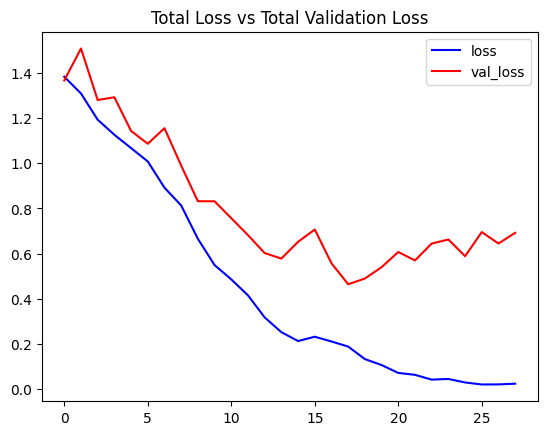

In [ ]:
# Visualizing the plot - TRAINING VS VALIDATION

PlotMetrics(ConvLSTM_Model_Training_History,'loss','val_loss','Total Loss vs Total Validation Loss')


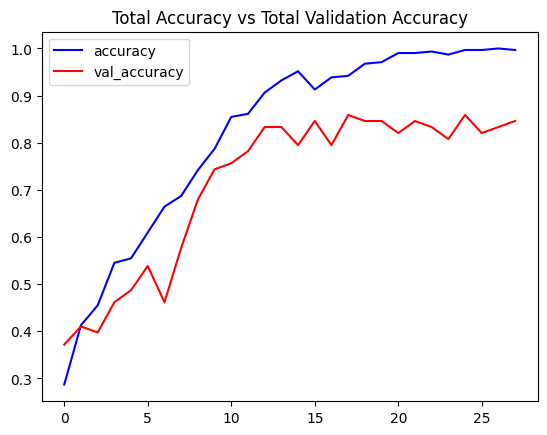

In [ ]:
# Visualizing the plot - TOTAL ACCURACY VS TOTAL VALIDATION ACCURACY

PlotMetrics(ConvLSTM_Model_Training_History,'accuracy','val_accuracy','Total Accuracy vs Total Validation Accuracy')


In [ ]:
# Implementing the LRCN
# LRCN - Long-term Recurrent Convolutional Network

#LSTM MODEL + LRCN Model

# CONSTRUCTING THE MODEL

def LRCN_Model():

  Model = Sequential()

  # Defining the Model Architecture
  # The TimeDistributed layer is used becuase the we're training in a video which
  # - is sequence of images where all the sequence should be passed in layer
  Model.add(TimeDistributed(Conv2D(16,(3,3),padding='same',activation = 'relu'),
                        input_shape = (SequenceLength, ImageHeight, ImageWidth,3)))

  Model.add(TimeDistributed(MaxPooling2D((4,4))))
  Model.add(TimeDistributed(Dropout(0.25)))


  Model.add(TimeDistributed(Conv2D(32,(3,3),padding='same',activation = 'relu'),
                        input_shape = (SequenceLength, ImageHeight, ImageWidth,3)))
  Model.add(TimeDistributed(MaxPooling2D((4,4))))
  Model.add(TimeDistributed(Dropout(0.25)))


  Model.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation = 'relu'),
                        input_shape = (SequenceLength, ImageHeight, ImageWidth,3)))
  Model.add(TimeDistributed(MaxPooling2D((2,2))))
  Model.add(TimeDistributed(Dropout(0.25)))


  Model.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation = 'relu'),
                        input_shape = (SequenceLength, ImageHeight, ImageWidth,3)))
  Model.add(TimeDistributed(MaxPooling2D((2,2))))


  Model.add(TimeDistributed(Flatten()))

  Model.add(LSTM(32))

  Model.add(Dense(len(ClassTrainList),activation = 'softmax'))


  # Displaying Model Summary

  Model.summary()

  # Returning LRCN Model
  return Model


In [ ]:
# Constructing required LRCN Model
lrcnModel = LRCN_Model()

print("Model Created Successfully")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDis  (None, 20, 64, 64, 16)   448       
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 20, 16, 16, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 20, 16, 16, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 20, 16, 16, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 20, 4, 4, 32)    

In [ ]:
# Compile and Train the model

EarlyStopping_CallBack = EarlyStopping(monitor="val_loss",patience=15,
                                       mode = "min",restore_best_weights = True)

# Specify the Loss Function

lrcnModel.compile(loss= "categorical_crossentropy",optimizer = "Adam",
                              metrics = ["accuracy"])

# Start Training the model

lrcnModel_Training_History = lrcnModel.fit(x=FeaturesTrain,y = LabelsTrain, epochs=70,
                                    batch_size = 4,shuffle = True, validation_split = 0.2,
                                callbacks = [EarlyStopping_CallBack])

Epoch 1/70
78/78 [==============================] - 27s 290ms/step - loss: 1.4075 - accuracy: 0.2581 - val_loss: 1.3754 - val_accuracy: 0.3462
Epoch 2/70
78/78 [==============================] - 19s 246ms/step - loss: 1.3721 - accuracy: 0.3032 - val_loss: 1.3637 - val_accuracy: 0.3205
Epoch 3/70
78/78 [==============================] - 19s 245ms/step - loss: 1.3393 - accuracy: 0.3226 - val_loss: 1.2861 - val_accuracy: 0.4103
Epoch 4/70
78/78 [==============================] - 18s 232ms/step - loss: 1.2410 - accuracy: 0.4387 - val_loss: 1.1332 - val_accuracy: 0.5128
Epoch 5/70
78/78 [==============================] - 17s 225ms/step - loss: 1.0164 - accuracy: 0.5645 - val_loss: 1.1453 - val_accuracy: 0.4872
Epoch 6/70
78/78 [==============================] - 19s 241ms/step - loss: 0.9362 - accuracy: 0.6258 - val_loss: 0.9634 - val_accuracy: 0.6026
Epoch 7/70
78/78 [==============================] - 19s 238ms/step - loss: 0.7800 - accuracy: 0.7161 - val_loss: 0.9221 - val_accuracy: 0.6667

In [ ]:
# Evaluation of Trained Model

Model_Evaluation_History = lrcnModel.evaluate(FeaturesTest, LabelsTest)

5/5 [==============================] - 4s 608ms/step - loss: 0.2762 - accuracy: 0.8923


In [ ]:
# Saving the Model

Model_Evaluation_Loss,Model_Evaluation_Accuracy = Model_Evaluation_History

# Defining datetime object
DateTimeFormat = '%Y_%m_%d__%H_%M_%S'
CurrentDateTime_dt = dt.datetime.now()
CurrentDateTime_String = dt.datetime.strftime(CurrentDateTime_dt,DateTimeFormat)

# Defining a useful name for the model
ModelFileName = f'lrcnModel__Date_Time_{CurrentDateTime_String}__Loss_{Model_Evaluation_Loss}__Accuracy_{Model_Evaluation_Accuracy}.h5'

# Save the Model

lrcnModel.save(ModelFileName)



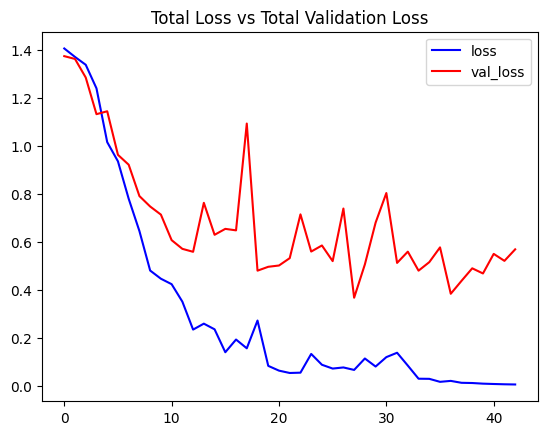

In [ ]:
# Plotting the Loss and Accuracy

# Visualizing the plot - TRAINING VS VALIDATION

PlotMetrics(lrcnModel_Training_History,'loss','val_loss','Total Loss vs Total Validation Loss')



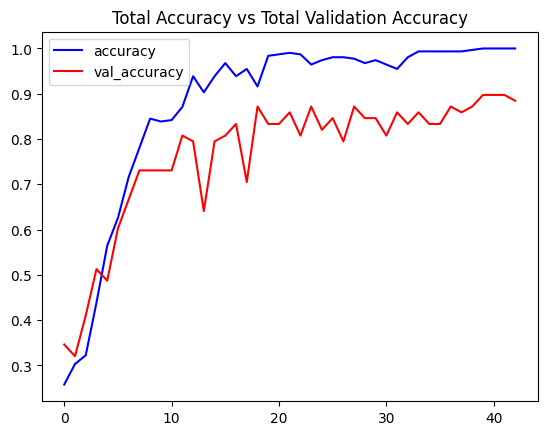

In [ ]:
# Visualizing the plot - TOTAL ACCURACY VS TOTAL VALIDATION ACCURACY

PlotMetrics(lrcnModel_Training_History,'accuracy','val_accuracy','Total Accuracy vs Total Validation Accuracy')


In [ ]:
import youtube_dl
from pandas.core.frame import FilePath
# Function to Download YouTube Video

def DownloadYTVideo(ytVideo_URL, OutputDirectory):

  # Creating a video object which contain useful info

  #Video = pafy.new(ytVideo_URL)

  # # Retrieve the title above
  # Title = Video.title

  # #Get the best quality video
  # BestVideo = Video.getbest()

  yt_dl_obj = youtube_dl.YoutubeDL()

  # Download the video
  BestVideo = yt_dl_obj.download([ytVideo_URL])

  # Get the title of the video
  Title = yt_dl_obj.info_dict['title']

  # Constructing the output file path
  OutputFilePath = f'{OutputDirectory}/{Title}.mp4'

  BestVideo.Download(FilePath = OutputFilePath, quiet = True)

  return Title



In [ ]:
 # Downloading the Testing Video

TestVideoDir = 'test_videos'

# Download a YT Video
VideoTitle = DownloadYTVideo("https://www.youtube.com/kzSJvEbIKi4",TestVideoDir)

InputVideoPath = f'{TestVideoDir}/{VideoTitle}.mp4'



In [ ]:
# Create a Function to Perform Action Recognition on Videos

def PredictVideos(VideoFilePath, OutputFilePath, SequenceLength):

  # Initializing to capture the object in the video
  VideoReader = cv2.VideoCapture(VideoFilePath)

  # Video Hight and Width
  OriginalVideoWidth = int(VideoReader.get(cv2.CAP_PROP_FRAME_WIDTH))
  OriginalVideoHeight = int(VideoReader.get(cv2.CAP_PROP_FRAME_HEIGHT))

  Video_writer = cv2.VideoWriter(OutputFilePath,cv2.VideoWriter_fourcc('M','P','4','V'))

  # Declaring a queue to store frames
  FramesQueue = deque(maxlen = SequenceLength)

  # Initializing a variable to store the predicted action being performed in the Video
  PredictedClassName = ''

  while VideoReader.isOpened():

    # Reading the Frame
    ok, Frame = VideoReader.read()

    if not ok:
      break

    # Resizing the Frame to the fixed Dimenstion
    ResizedFrame = cv2.resize(Frame,(ImageHeight,ImageWidth))

    # Normalize the resized frame
    NormalizedFrame = ResizedFrame / 255

    # Appending the pre-processed frame in the FrameList
    FramesQueue.append(NormalizedFrame)

    if len(FramesQueue) == SequenceLength:

      # Pass the normalized frame to the model to get predicted prob
      PredictedProb_label = lrcnModel.predict(np.expand_dims(FramesQueue,axis = 0))[0]

      PredictedLabel = np.argmax(PredictedProb_label)

      # Getting the index of the class with highest probability
      PredictedClassName = ClassTrainList[PredictedLabel]

    cv2.putText(Frame, PredictedClassName, (10,30),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)

    cv2.VideoWriter.write(Frame)

  VideoReader.release()
  VideoWriter.release()



In [ ]:
# Perform Action Recognition on the Test Video

OutputFilePath = f'{TestVideoDir}/{VideoTitle}-Output-SeqLen{SequenceLength}.mp4'

# Perform Action Recognition on the Test Video

PredictVideos(InputVideoPath,OutputFilePath,SequenceLength)

# Displaying the Output Video
VideoFileClip(OutputFilePath, audio = False, target_resolution=(300,None)).ipython_display()


In [ ]:
# Creating a Function to perform a Single Prediction on Videos

def PredictSingleAction (VideoFilePath, SequenceLength):

  #Initializing the VideoCapture
  VideoReader = cv2.VideoCapture(VideoFilePath)
  OriginalVideoWidth = int(VideoReader.get(cv2.CAP_PROP_FRAME_WIDTH))
  OriginalVideoHieght = int(VideoReader.get(cv2.CAP_PROP_FRAME_HEIGHT))


  FramesList = []

  # Variable to store number of frames
  PredictedClassname = ''

  # Number of Frames in the Video
  VideoFrameCount = int(VideoReader.get(cv2.CAP_PROP_FRAME_COUNT))

  # Skip the interval once added to the list of frames
  SkipFrameWindow = max(int(VideoFrameCount/SequenceLength),1)

  # Iterating the number of times equal to fixed length of seq
  for FrameCounter in range(SequenceLength):
    VideoReader.set(cv2.CAP_PROP_POS_FRAMES,FrameCounter*SkipFrameWindow)

    #Reading frame
    success, Frame = VideoReader.read()

    if not success:
      break

    ResizedFrame = cv2.resize(Frame,(ImageHeight,ImageWidth))

    # Normalizing the resized frame
    NormalizedFrame = ResizedFrame/255

    # Appending the preprocessed frame in the list
    FramesList.append(NormalizedFrame)


  # Passing the preprocessed frame to the model to get predicted
  PredictedLabelProb = lrcnModel.predict(np.expand_dims(FramesList,axis = 0))[0]

  # Getting the index of the class with high probability
  PredictedLabel = np.argmax(PredictedLabelProb)

  # Class name using retrived index
  PredictedClassName =  ClassTrainList[PredictedLabel]

  print(f'Action Predicted: {PredictedClassName} \nConfidence: {PredictedLabelProb[PredictedLabel]}')

  VideoReader.reader()

In [ ]:
 # Downloading the Testing Video

TestVideoDir = 'test_videos'

# Download a YT Video
VideoTitle = DownloadYTVideo("https://www.youtube.com/watch?v=kzSJvEbIKi4",TestVideoDir)

InputVideoPath = f'{TestVideoDir}/{VideoTitle}.mp4'

PredictSingleAction(InputVideoPath,SequenceLength)

VideoFileClip(InputVideoPath , audio = False, target_resolution=(300,None)).ipython_display()
